In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/avantika hans/wheat disease/training/Wheat Disease Detection",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2078 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Brown_rust', 'Fusarium Head Blight', 'Healthy', 'Yellow_rust', 'septoria']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 2 4 0 0 4 2 4 4 0 4 0 2 0 4 0 2 4 0 0 0 4 0 4 2 4 0 4 0]


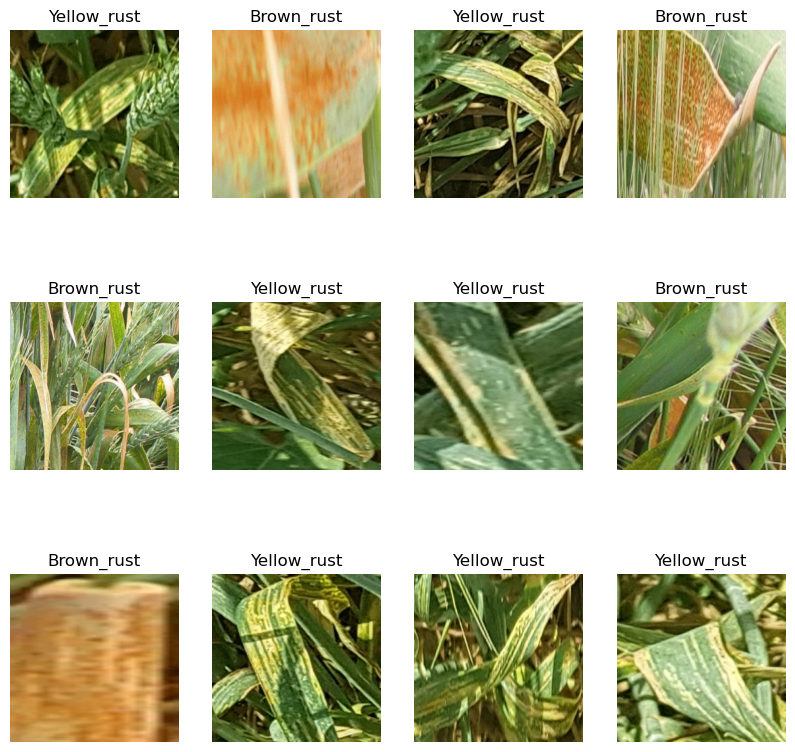

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

64

In [8]:
92*32

2944

In [9]:
train_size = 0.8
len(dataset)*train_size

51.2

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

10

In [12]:
val_size=0.1
len(dataset)*val_size

6.4

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

4

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

51

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

7

### Cache, Shuffle, and Prefetch the Dataset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#### Applying Data Augmentation to Train Dataset

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
51/51 [==============================] - 99s 2s/step - loss: 1.1881 - accuracy: 0.4491 - val_loss: 0.9374 - val_accuracy: 0.7188
Epoch 2/50
51/51 [==============================] - 72s 1s/step - loss: 0.7948 - accuracy: 0.7114 - val_loss: 0.7022 - val_accuracy: 0.8125
Epoch 3/50
51/51 [==============================] - 71s 1s/step - loss: 0.5991 - accuracy: 0.8021 - val_loss: 0.6409 - val_accuracy: 0.8125
Epoch 4/50
51/51 [==============================] - 71s 1s/step - loss: 0.4265 - accuracy: 0.8670 - val_loss: 0.4001 - val_accuracy: 0.8854
Epoch 5/50
51/51 [==============================] - 70s 1s/step - loss: 0.4382 - accuracy: 0.8609 - val_loss: 0.3251 - val_accuracy: 0.9062
Epoch 6/50
51/51 [==============================] - 74s 1s/step - loss: 0.3252 - accuracy: 0.9007 - val_loss: 0.2747 - val_accuracy: 0.8958
Epoch 7/50
51/51 [==============================] - 72s 1s/step - loss: 0.2820 - accuracy: 0.9069 - val_loss: 0.2580 - val_accuracy: 0.9271
Epoch 8/50
51/51 [==

In [28]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 15s 292ms/step - loss: 0.0765 - accuracy: 0.9732


In [33]:


# Assuming 'y_true' is the true labels and 'y_pred' is the predicted labels
y_true = [0, 1, 0, 0, 1, 1]
y_pred = [0, 1, 1, 0, 0, 1]

# Convert the lists to TensorFlow tensors
y_true = tf.convert_to_tensor(y_true)
y_pred = tf.convert_to_tensor(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate precision
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
print("Precision:", precision)
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print("Recall:", recall)

# Calculate specificity
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print("Specificity:", specificity)

# Calculate accuracy
accuracy = (cm[0, 0] + cm[1, 1]) / (cm[0, 0] + cm[0, 1] + cm[1, 0] + cm[1, 1])
print("Accuracy:", accuracy)

Precision: 0.6666666666666666
Recall: 0.6666666666666666
Specificity: 0.6666666666666666
Accuracy: 0.6666666666666666


In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 51}

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
type(history.history['loss'])

list

In [38]:
len(history.history['loss'])

50

In [39]:
history.history['loss'][:10] # show loss for first 10 epochs

[1.1881227493286133,
 0.7947636842727661,
 0.5990727543830872,
 0.4264824390411377,
 0.43817099928855896,
 0.3252074718475342,
 0.2820320427417755,
 0.2739039957523346,
 0.299026757478714,
 0.27928194403648376]

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

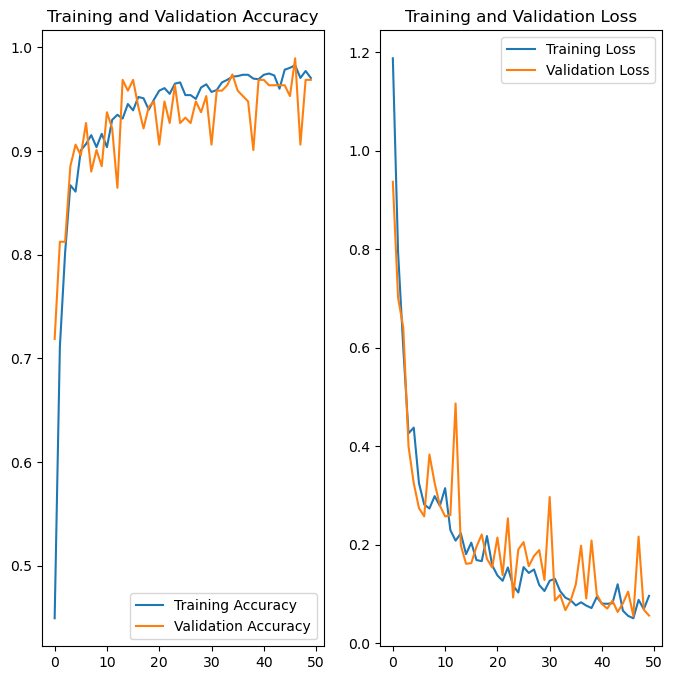

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()